<a href="https://colab.research.google.com/github/duncansnh/burn-mapping/blob/master/CUU_burn_extent_indices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Script to create indices from ARD of 10 bands from Sentinel 2. Creates rasters float 32. **Note** - If the number of indices is altered, count= will need updating. August 2020.
     

In [ ]:
#This is only required if running in colab notebook to install the libraries
#If running Python code elsewhere need to make sure below libraries are installed
! pip install geopandas
! pip install descartes
! pip install rasterio
! pip install rasterstats

     |████████████████████████████████| 972kB 3.4MB/s 
     |████████████████████████████████| 14.8MB 302kB/s 
     |████████████████████████████████| 10.9MB 45.7MB/s 
     |████████████████████████████████| 18.3MB 66.5MB/s 
     |████████████████████████████████| 133kB 4.9MB/s 


In [ ]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import os
import json
#from sklearn.model_selection import train_test_split
import geopandas as gpd
import descartes
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from shapely.geometry import mapping
from rasterstats import zonal_stats
import datetime
import math

In [ ]:
#Only if running in Google Colab, in which case input images need to be in Google Drive.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Set working drive.

In [ ]:

wd = '/content/drive/My Drive'
#iteration = 'CUU_burn_cairngorms'
iteration = 'CUU_burn_skye'

###Set image directory

In [ ]:
image_dir = os.path.join(wd, 'Imagery')



###Start timer log.

In [ ]:
starttime1 = datetime.datetime.now()

###Input parameters

In [ ]:
# Cairngorms
#inraster1 = 'S2A_20190312_final2.tif'
#inraster2 = 'S2B_20190516_final2.tif'

# Skye
inraster1 = 'S2A_20180225_img_10N.tif'
inraster2 = 'S2A_20180317_img.tif'

#number of bands required in output raster for Count paramater
C = 21

###'open' pre and post fire rasters, check dimensions are the same and update profile for output

In [ ]:
#Read images
s2pre = rasterio.open(os.path.join(image_dir,inraster1))
#Print number of bands
B = s2pre.count
print(B)
print(s2pre.shape)

#Copy raster profile to for later output
s2prof = s2pre.profile.copy()

s2post = rasterio.open(os.path.join(image_dir,inraster2))
#Print number of bands
B = s2post.count
print(B)
print(s2post.shape)


10
(5850, 5263)
10
(5850, 5263)


#calculate indices for whole image - windowed read/ write

In [ ]:

#output greater than 4GB therefore needs to be BigTIFF
s2prof.update(count=C, nodata=None, dtype=np.float32, BIGTIFF="IF_SAFER")
print((s2prof))

with rasterio.open(os.path.join(image_dir,'{}_indices.tif'.format(iteration)), 'w', **s2prof) as dst:
  for block_index, window in dst.block_windows(1):
    #read in each band of pre fire image for current window
    s2pre_block_blue = s2pre.read(1, window=window, masked=True).astype(float)
    s2pre_block_green = s2pre.read(2, window=window, masked=True).astype(float)
    s2pre_block_red = s2pre.read(3, window=window, masked=True).astype(float)
    s2pre_block_re5 = s2pre.read(4, window=window, masked=True).astype(float)
    s2pre_block_re6 = s2pre.read(5, window=window, masked=True).astype(float)
    s2pre_block_re7 = s2pre.read(6, window=window, masked=True).astype(float)
    s2pre_block_NIR = s2pre.read(7, window=window, masked=True).astype(float)
    s2pre_block_NIR8A = s2pre.read(8, window=window, masked=True).astype(float)
    s2pre_block_SWIR1 = s2pre.read(9, window=window, masked=True).astype(float)
    s2pre_block_SWIR2 = s2pre.read(10, window=window, masked=True).astype(float)

    #read in each band of post fire image for current window
    s2post_block_blue = s2post.read(1, window=window, masked=True).astype(float)
    s2post_block_green = s2post.read(2, window=window, masked=True).astype(float)
    s2post_block_red = s2post.read(3, window=window, masked=True).astype(float)
    s2post_block_re5 = s2post.read(4, window=window, masked=True).astype(float)
    s2post_block_re6 = s2post.read(5, window=window, masked=True).astype(float)
    s2post_block_re7 = s2post.read(6, window=window, masked=True).astype(float)
    s2post_block_NIR = s2post.read(7, window=window, masked=True).astype(float)
    s2post_block_NIR8A = s2post.read(8, window=window, masked=True).astype(float)
    s2post_block_SWIR1 = s2post.read(9, window=window, masked=True).astype(float)
    s2post_block_SWIR2 = s2post.read(10, window=window, masked=True).astype(float)
    
   
    np.seterr(divide='ignore', invalid = 'ignore' ) #ignore errors from calculating indices/ ratios#over= 'ignore', under = 'ignore' 

    # calculate indices and convert to float
    # NBR is the opposite way round to normal but recommended by Filiponi: to make the behavior of the indices consistent
    # the values of all the indices increase if fire has occurred
    
    pre_nbr = ((s2pre_block_SWIR1 - s2pre_block_NIR)/(s2pre_block_SWIR1 + s2pre_block_NIR))
    pre_nbr = pre_nbr.astype(rasterio.float32)
    post_nbr = ((s2post_block_SWIR1 - s2post_block_NIR)/(s2post_block_SWIR1 + s2post_block_NIR))
    post_nbr = post_nbr.astype(rasterio.float32)
    dnbr = post_nbr - pre_nbr
    dnbr = dnbr.astype(rasterio.float32)

    # nbr2
    pre_nbr2 = ((s2pre_block_SWIR2 - s2pre_block_SWIR1)/(s2pre_block_SWIR2 + s2pre_block_SWIR1))
    pre_nbr2 = pre_nbr2.astype(rasterio.float32)
    post_nbr2 = ((s2post_block_SWIR2 - s2pre_block_SWIR1)/(s2post_block_SWIR2 + s2pre_block_SWIR1))
    post_nbr2 = post_nbr2.astype(rasterio.float32)
    dnbr2 = post_nbr2 - pre_nbr2
    dnbr2 = dnbr2.astype(rasterio.float32)

    # ndvi
    pre_ndvi = (-1 * ((s2pre_block_NIR - s2pre_block_red)/(s2pre_block_NIR + s2pre_block_red)))
    pre_ndvi = pre_ndvi.astype(rasterio.float32)
    post_ndvi = (-1 *((s2post_block_NIR - s2post_block_red)/(s2post_block_NIR + s2post_block_red)))
    post_ndvi = post_ndvi.astype(rasterio.float32)
    dndvi = post_ndvi - pre_ndvi
    dndvi = dndvi.astype(rasterio.float32)

    # normalised MIRBI - designed for savannah ecosystems
    pre_nmirbi = (((10 * s2pre_block_SWIR2)-(9.8 * s2pre_block_SWIR1 + 2)) / ((10 * s2pre_block_SWIR2)+ (9.8 * s2pre_block_SWIR1 + 2)))
    pre_nmirbi = pre_nmirbi.astype(rasterio.float32)
    post_nmirbi = (((10 * s2post_block_SWIR2)-(9.8 * s2post_block_SWIR1 + 2)) / ((10 * s2post_block_SWIR2)+ (9.8 * s2post_block_SWIR1 + 2)))
    post_nmirbi = post_nmirbi.astype(rasterio.float32)
    dnmirbi = post_nmirbi - pre_nmirbi
    dnmirbi = dnmirbi.astype(rasterio.float32)
    
 
    # char soil index
    pre_csi = (-1 * (s2pre_block_NIR / s2pre_block_SWIR2))
    pre_csi = pre_csi.astype(rasterio.float32)
    post_csi = (-1 * (s2post_block_NIR / s2post_block_SWIR2))
    post_csi = post_csi.astype(rasterio.float32)
    dcsi = post_csi - pre_csi
    dcsi = dcsi.astype(rasterio.float32)

    # BAIS2
    pre_bais2 = (-1 * (((1 - np.sqrt((s2pre_block_re6 * s2pre_block_re7 * s2pre_block_NIR8A) / s2pre_block_red)) * (((s2pre_block_SWIR2 - s2pre_block_NIR8A) / (np.sqrt(s2pre_block_SWIR2 + s2pre_block_NIR8A))) + 1))))
    pre_bais2 = pre_bais2.astype(rasterio.float32)
    post_bais2 =(-1 * (((1 - np.sqrt((s2post_block_re6 * s2post_block_re7 * s2post_block_NIR8A) / s2post_block_red)) * (((s2post_block_SWIR2 - s2post_block_NIR8A) / (np.sqrt(s2post_block_SWIR2 + s2post_block_NIR8A))) + 1))))
    post_bais2 = post_bais2.astype(rasterio.float32)
    dbais2 = post_bais2 - pre_bais2
    dbais2 = dbais2.astype(rasterio.float32)

    # SAVI L = 0.5
    pre_savi = (-1 * (1.5 * ((s2pre_block_NIR - s2pre_block_red) / (s2pre_block_NIR + s2pre_block_red + 0.5))))
    pre_savi = pre_savi.astype(rasterio.float32)
    post_savi = (-1 * (1.5 * ((s2post_block_NIR - s2post_block_red) / (s2post_block_NIR + s2post_block_red + 0.5))))
    post_savi = post_savi.astype(rasterio.float32)
    dsavi = post_savi - pre_savi
    dsavi = dsavi.astype(rasterio.float32)

    #write results for current window
    dst.write_band(1, pre_nbr, window = window)
    dst.write_band(2, post_nbr, window = window)
    dst.write_band(3, dnbr, window = window)
    dst.write_band(4, pre_nbr2, window = window)
    dst.write_band(5, post_nbr2, window = window)
    dst.write_band(6, dnbr2, window = window)
    dst.write_band(7, pre_ndvi, window = window)
    dst.write_band(8, post_ndvi, window = window)
    dst.write_band(9, dndvi, window = window)
    dst.write_band(10, pre_nmirbi, window = window)
    dst.write_band(11, post_nmirbi, window = window)
    dst.write_band(12, dnmirbi, window = window)
    dst.write_band(13, pre_csi, window = window)
    dst.write_band(14, post_csi, window = window)
    dst.write_band(15, dcsi, window = window)
    dst.write_band(16, pre_bais2, window = window)
    dst.write_band(17, post_bais2, window = window)
    dst.write_band(18, dbais2, window = window)
    dst.write_band(19, pre_savi, window = window)
    dst.write_band(20, post_savi, window = window)
    dst.write_band(21, dsavi, window = window)
    
    


{'driver': 'GTiff', 'dtype': <class 'numpy.float32'>, 'nodata': None, 'width': 5263, 'height': 5850, 'count': 21, 'crs': CRS.from_wkt('PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(10.0, 0.0, 112370.0,
       0.0, -10.0, 877510.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel', 'BIGTIFF': 'IF_SAFER'}


record time taken 

In [ ]:
endtime1=datetime.datetime.now()
deltatime1=endtime1-starttime1
print(("Time to read in S2 image:  {0}  hr:min:sec".format(deltatime1))) 


Visualise image, check output


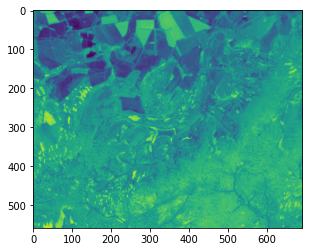

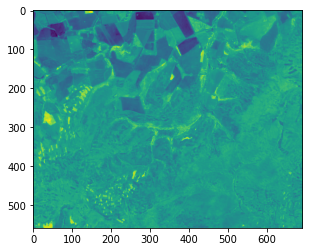

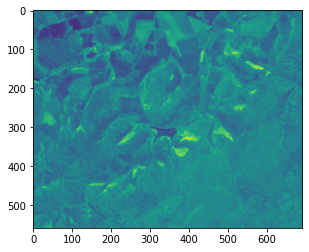

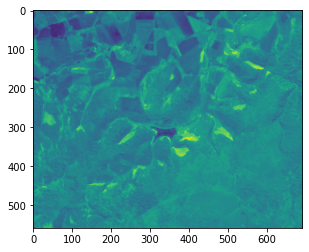

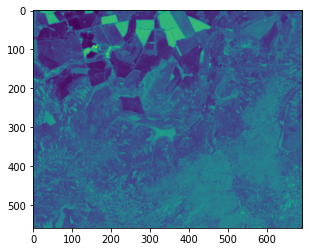

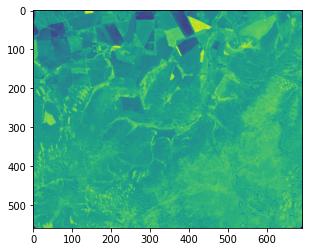

In [ ]:

plotraster = rasterio.open(os.path.join(image_dir,'{}_indices.tif'.format(iteration)))

from rasterio.plot import show

#post fire nbr
show(plotraster.read(2))
show(plotraster.read(3))
show(plotraster.read(5))
show(plotraster.read(6))
show(plotraster.read(20))
show(plotraster.read(21))
plotraster.close()
